# 1. Импорт необходимых библиотек и модулей

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from os import listdir
import pandas as pd
import tensorflow as tf

# print("TensorFlow version:", tf.__version__)

%matplotlib inline

# 2. Чтение данных из файла
## 2.1 Чтение экспериментальных данных из .csv

In [2]:
file_name = 'test.csv'

# TIME_CONSTANT = 0.005
# AMPL = 3.0
# F_PULSE = 20 * 10 ** (-6)
# STDDEV = 0.2

In [3]:
data = pd.read_csv(file_name, 
                   header = 0,
                   parse_dates = [0],
                   infer_datetime_format = True
                  )
data.head()

,frequency_hz,dlts_pf,f_pulse
0,1.0,0.024528,0.00002
1,1.0078626272670832,-0.200976,0.00002
2,1.0157870754417073,0.004056,0.00002
3,1.023773830598626,0.252659,0.00002
4,1.031823382634417,0.307020,0.00002


## 2.2 Подготовка данных для TensorFlow

In [4]:
dlts = tf.Variable(data.dlts_pf.to_numpy(), 
                   dtype = 'float64')

frequency = tf.Variable(data.frequency_hz.to_numpy(),
                        dtype = 'float64')

# filling_pulse = tf.Variable(data.f_pulse.mean() * 10**-6, dtype = 'float64')
filling_pulse = tf.Variable(data.f_pulse.mean(), dtype = 'float64')

In [5]:
# dlts

In [6]:
# frequency

In [7]:
filling_pulse

<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=1.999999999999952e-05>

## 2.3 График

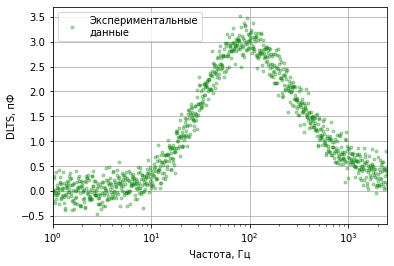

In [8]:
plt.semilogx(frequency.numpy(), dlts.numpy(), '.g', label='Экспериментальные\nданные', alpha = 0.3)
plt.grid()
plt.xlim([1, 2500])
# plt.ylim([-0.006, 0])
plt.legend()
plt.ylabel('DLTS, пФ')
plt.xlabel('Частота, Гц')
plt.show()

## 2.4 Подготовка данных

In [9]:
frequency = np.log10(frequency)
# frequency

In [10]:
scale_factor = np.max(frequency) / (np.max(dlts) - np.min(dlts))
dlts = dlts * scale_factor
# dlts

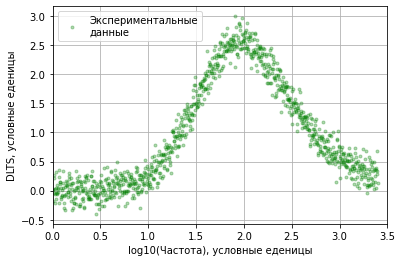

In [11]:
plt.plot(frequency, dlts, '.g', label='Экспериментальные\nданные', alpha=0.3)
plt.grid()
plt.xlim([0, 3.5])
# plt.ylim([-3.5, 0])
plt.legend()
plt.ylabel('DLTS, условные еденицы')
plt.xlabel('log10(Частота), условные еденицы')
plt.show()

# 3. Описание модели
Выходной сигнал коррелятора спектрометра DLS-82E определяется выражением:
\begin{equation}
    \label{eq:eq1}
    S\left(\tau,C_A,F_0, t_1\right) = C_A K_{BS} K_{LS} \phi\left(\tau,F_0,t_1\right),
\end{equation}
где  
$C_A$ - амплитуда емкостного релаксационного сигнала,  
$K_{BS}$ - масштабный коэффициент, зависящий от чувствительности емкостного моста,  
$K_{LS}$ - масштабный коэффициент селектора,  
$\tau$ - постоянная времени релаксации гулбокого уровня,  
$F_0$ - частота сканирования импульсов заполнения,  
$t_1$ - длительность импульса заполнения,  
$\phi\left(\tau,F_0,t_1\right)$ - функция определяемая выражением:  
\begin{equation}
    \label{eq:eq2}
    \phi\left(\tau,F_0,t_1\right) = 
    M \tau F_0 e^{-\frac{0.05}{\tau F_0}}
    \left(1-e^{\frac{t_1 F_0-0.45}{\tau F_0}}
    -e^{-\frac{0.5}{\tau F_0}}+
    e^{\frac{t_1 F_0-0.95}{\tau F_0}}\right),
\end{equation}
где $M$ -- масштабный множитель.

Таким образом,
$$  M = \frac{1}{\max{\left[
    \tau F_0 e^{-\frac{0.05}{\tau F_0}}
    \left(1-e^{\frac{t_1 F_0-0.45}{\tau F_0}}
    -e^{-\frac{0.5}{\tau F_0}}+
    e^{\frac{t_1 F_0-0.95}{\tau F_0}}\right)
    \right]}}
$$

# 4. Кодирование модели
## 4.1 Функция `get_phi()`
$$ \tau = 10^{time\_constant\_power} $$
$$ F_0 = 10^{frequency\_power}$$
$$ a = \tau F_0 $$
$$ b = t_1 F_0 $$
$$ exp0 = \exp{\left(\frac{-0.05}{a}\right)} $$
$$ exp1 = \exp{\left(\frac{b-0.45}{a}\right)} $$
$$ exp2 = \exp{\left(\frac{-0.5}{a}\right)} $$
$$ exp3 = \exp{\left(\frac{b-0.95}{a}\right)} $$
$$ \phi = M \cdot a \cdot exp0 \cdot \left(1.0 - exp1 - exp2 + exp3\right) $$

In [12]:
def get_phi(frequency_power, time_constant_power, M, filling_pulse):
    time_constant = tf.pow(10.0, time_constant_power)
    frequency = tf.pow(10, frequency_power)

    a = time_constant * frequency
    b = filling_pulse * frequency

    exp0 = tf.exp(-0.05 / (a))
    exp1 = tf.exp((b - 0.45) / (a))
    exp2 = tf.exp(-0.5 / (a))
    exp3 = tf.exp((b - 0.95) / (a))

    phi = M * a * exp0 * (1.0 - exp1 - exp2 + exp3)

    return phi

## 4.2 Функция `get_dlts()`
$$ DLTS = A \cdot \phi^{p\_coef} $$

In [13]:
# def get_dlts(amplitude, M, frequency_power, time_constant_power, filling_pulse):
#     dlts = amplitude * get_phi(frequency_power, 
#                                time_constant_power, 
#                                M, 
#                                filling_pulse)
    
#     return dlts

## 4.3 Определение функции потерь для DLTS (для модели). Функция `loss_dlts()`
Среднеквадратическая ошибка


In [14]:
# def loss(target_y, predicted_y):
#     return tf.reduce_mean(tf.square(target_y - predicted_y))

## 4.5 Определение модели для $\phi$

In [15]:
class PhiModel(tf.Module):
    def __init__(self, 
                 time_constant_power,
                 filling_pulse,
                 M = 5.861,
                 **kwargs):
        
        super().__init__(**kwargs)
        
        self.time_constant_power = tf.Variable(time_constant_power, 
                                               dtype='float64', 
                                               name='time constant power'
                                              )
        self.filling_pulse = tf.Variable(filling_pulse, 
                                         dtype='float64',
                                         name='filling pulse'
                                        )
        self.M = tf.Variable(M, 
                             dtype='float64',
                             name='M'
                            )
        
    def __call__(self, frequency_power):
        return get_phi(frequency_power, 
                       self.time_constant_power, 
                       self.M, 
                       self.filling_pulse)
    
    
phi_model = PhiModel(time_constant_power=tf.Variable(-3.0, dtype='float64'), 
                     filling_pulse=filling_pulse)

for i, v in enumerate(phi_model.variables):
    print(f'Variable {i}:', v)

print(phi_model(frequency_power=tf.Variable(3.0, dtype='float64')))

Variable 0: <tf.Variable 'M:0' shape=() dtype=float64, numpy=5.861>
Variable 1: <tf.Variable 'filling pulse:0' shape=() dtype=float64, numpy=1.999999999999952e-05>
Variable 2: <tf.Variable 'time constant power:0' shape=() dtype=float64, numpy=-3.0>
tf.Tensor(0.7666617093509145, shape=(), dtype=float64)


## 4.6 Идентификация коэффициента $M$

In [16]:
def train_M(phi_model,
            learning_rate=0.1,
            n_iters=100,
            stop_val = None,
            verbose = False
           ):
    
    prev_loss = tf.Variable(np.inf, dtype='float64')
    max_freq_pow = tf.Variable(-phi_model.time_constant_power, dtype='float64')
    
    for _ in range(n_iters):
        with tf.GradientTape() as tape:
            current_loss = 0.0 - phi_model(max_freq_pow)
            
        if verbose:
            print(_)
            print(current_loss)
            print(max_freq_pow)
        
        if stop_val is not None:
            if tf.abs(current_loss - prev_loss) < stop_val:
                break
        
        dfreq_pow = tape.gradient(current_loss, max_freq_pow)
        max_freq_pow.assign_sub(learning_rate * dfreq_pow)
        
        prev_loss = current_loss
        
    phi_model.M = phi_model.M / phi_model(max_freq_pow)

In [17]:
train_M(phi_model,
        learning_rate=0.2,
        n_iters=100,
        stop_val = 10**-10,
        verbose = True
       )

0
tf.Tensor(-0.7666617093509145, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=3.0>
1
tf.Tensor(-0.9330581559008368, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.802874102155242>
2
tf.Tensor(-0.9859552099662315, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.676580828604517>
3
tf.Tensor(-0.9896401527850606, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.640731963100184>
4
tf.Tensor(-0.98970905667989, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.6357570793749963>
5
tf.Tensor(-0.9897099286163724, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.635196461552543>
6
tf.Tensor(-0.9897099390884785, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.635135011043419>
7
tf.Tensor(-0.9897099392135181, shape=(), dtype=float64)
<tf.Variable 'Variable:0' 

In [18]:
phi_model.M

<tf.Tensor: shape=(), dtype=float64, numpy=5.921937092648238>

In [19]:
del phi_model

## 4.7 Определение модели частотного скана

In [20]:
class FeqScanModel(tf.Module):
    
    def __init__(self,
                 amplitude,
                 time_constant_power,
                 filling_pulse,
                 fit_p = False,
                 **kwargs):
        super().__init__(**kwargs)
        
        self.amplitude = tf.Variable(amplitude, dtype='float64')
        
        self.filling_pulse = tf.Variable(filling_pulse, dtype='float64')
        
        self.time_constant_power = tf.Variable(time_constant_power, dtype='float64')
    
        self.phi_model = PhiModel(time_constant_power=self.time_constant_power, 
                                  filling_pulse=self.filling_pulse)
        
        train_M(self.phi_model,
                learning_rate=0.2,
                n_iters=100,
                stop_val = 10**-10,
                verbose = False
               )
        
        self.fit_p = fit_p
        self.p_coef = tf.Variable(1.0, dtype = 'float64')
        
        

    def __call__(self, frequency_power):
        return self.amplitude * self.phi_model(frequency_power) ** self.p_coef
    
    
    def fit(self, 
            f_powers, 
            dlts_vals,
            learning_rate = 0.1,
            n_iters = 1000,
            stop_val = None,
            verbose = False
           ):
        frequency_powers = tf.Variable(f_powers, dtype='float64')
        dlts = tf.Variable(dlts_vals, dtype='float64')
        
        prev_loss = tf.Variable(np.inf, dtype='float64')
        
        for _ in range(n_iters):
            
            train_M(self.phi_model,
                    learning_rate=0.2,
                    n_iters=100,
                    stop_val = 10**-10,
                   )
        
            with tf.GradientTape() as tape:
                predicted_dlts = self.__call__(frequency_powers)
                current_loss = tf.reduce_mean(tf.square(dlts - predicted_dlts))

            if self.fit_p:
                dampl, dtime_const_pow, dp_coef = tape.gradient(current_loss, [self.amplitude, 
                                                                               self.phi_model.time_constant_power,
                                                                               self.p_coef
                                                                              ])
            else:
                dampl, dtime_const_pow = tape.gradient(current_loss, [self.amplitude, 
                                                                      self.phi_model.time_constant_power])

            self.amplitude.assign_sub(learning_rate * dampl)
            self.phi_model.time_constant_power.assign_sub(learning_rate * dtime_const_pow)
            if self.fit_p:
                self.p_coef.assign_sub(learning_rate * dp_coef)
            
            
            self.time_constant_power = self.phi_model.time_constant_power
            
            if verbose:
                print('iter #', _)
                print('amp:',self.amplitude)
                print('tau:',self.time_constant_power)
                print('M:', self.phi_model.M)
                print('p:', self.p_coef)
                print('Loss:', current_loss)
            
            if stop_val is not None:
                if tf.abs(current_loss - prev_loss) < stop_val:
                    break
                    
            prev_loss = current_loss

## 4.8 Проверка модели с $p\_coef = 1$

In [21]:
fs_model = FeqScanModel(amplitude = 2.0,
                        time_constant_power = -2.5,
                        filling_pulse = 20.0*10**-6)

In [22]:
new_frequency = tf.Variable(frequency, dtype='float64')

In [23]:
new_dlts = fs_model(new_frequency)

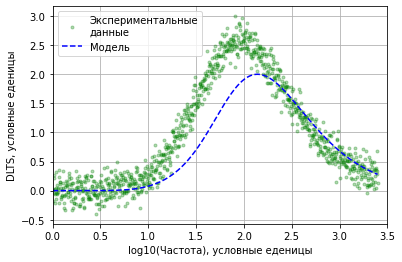

In [24]:
plt.plot(frequency, dlts, '.g', label='Экспериментальные\nданные', alpha=0.3)
plt.plot(new_frequency.numpy(), new_dlts.numpy(), '--b', label='Модель')
plt.grid()
plt.xlim([0, 3.5])
# plt.ylim([-3.5, 0])
plt.legend()
plt.ylabel('DLTS, условные еденицы')
plt.xlabel('log10(Частота), условные еденицы')
plt.show()

In [25]:
fs_model.fit(f_powers = tf.Variable(frequency, dtype='float64'), 
             dlts_vals = tf.Variable(dlts, dtype='float64'),
             learning_rate = 0.2,
             n_iters = 1000,
             stop_val = 10**-10,
             verbose = True
            )

iter # 0
amp: <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.0494168469734024>
tau: <tf.Variable 'time constant power:0' shape=() dtype=float64, numpy=-2.3074182665502763>
M: tf.Tensor(5.876559642051986, shape=(), dtype=float64)
p: <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=1.0>
Loss: tf.Tensor(0.2080145378996923, shape=(), dtype=float64)
iter # 1
amp: <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.10283576588353>
tau: <tf.Variable 'time constant power:0' shape=() dtype=float64, numpy=-2.2984520638504042>
M: tf.Tensor(5.8690652099080935, shape=(), dtype=float64)
p: <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=1.0>
Loss: tf.Tensor(0.0957038685416496, shape=(), dtype=float64)
iter # 2
amp: <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.1506448973083954>
tau: <tf.Variable 'time constant power:0' shape=() dtype=float64, numpy=-2.2989024610835105>
M: tf.Tensor(5.868790910828283, shape=(), dtype=float64)
p: <tf.Variable 'Variable:0' sh

iter # 27
amp: <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.5331323479414265>
tau: <tf.Variable 'time constant power:0' shape=() dtype=float64, numpy=-2.300415967483096>
M: tf.Tensor(5.86885014886542, shape=(), dtype=float64)
p: <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=1.0>
Loss: tf.Tensor(0.02773806864048126, shape=(), dtype=float64)
iter # 28
amp: <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.5358145982340896>
tau: <tf.Variable 'time constant power:0' shape=() dtype=float64, numpy=-2.3004265217724713>
M: tf.Tensor(5.868850507533142, shape=(), dtype=float64)
p: <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=1.0>
Loss: tf.Tensor(0.027695524777820467, shape=(), dtype=float64)
iter # 29
amp: <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.5382155524198566>
tau: <tf.Variable 'time constant power:0' shape=() dtype=float64, numpy=-2.300435967870471>
M: tf.Tensor(5.8688508285437555, shape=(), dtype=float64)
p: <tf.Variable 'Variable:

iter # 53
amp: <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.557273561666479>
tau: <tf.Variable 'time constant power:0' shape=() dtype=float64, numpy=-2.300510904158427>
M: tf.Tensor(5.868853375230469, shape=(), dtype=float64)
p: <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=1.0>
Loss: tf.Tensor(0.027524682938393667, shape=(), dtype=float64)
iter # 54
amp: <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.557424049178238>
tau: <tf.Variable 'time constant power:0' shape=() dtype=float64, numpy=-2.3005114955716026>
M: tf.Tensor(5.868853395330181, shape=(), dtype=float64)
p: <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=1.0>
Loss: tf.Tensor(0.027524549020316775, shape=(), dtype=float64)
iter # 55
amp: <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.5575587546262377>
tau: <tf.Variable 'time constant power:0' shape=() dtype=float64, numpy=-2.3005120249575515>
M: tf.Tensor(5.868853413321853, shape=(), dtype=float64)
p: <tf.Variable 'Variable:

amp: <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.558644005651804>
tau: <tf.Variable 'time constant power:0' shape=() dtype=float64, numpy=-2.300516289804168>
M: tf.Tensor(5.868853558266942, shape=(), dtype=float64)
p: <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=1.0>
Loss: tf.Tensor(0.027524010489939913, shape=(), dtype=float64)
iter # 82
amp: <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.5586507707200536>
tau: <tf.Variable 'time constant power:0' shape=() dtype=float64, numpy=-2.3005163163889333>
M: tf.Tensor(5.868853559170455, shape=(), dtype=float64)
p: <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=1.0>
Loss: tf.Tensor(0.027524010219305686, shape=(), dtype=float64)
iter # 83
amp: <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.558656826315989>
tau: <tf.Variable 'time constant power:0' shape=() dtype=float64, numpy=-2.30051634018567>
M: tf.Tensor(5.868853559979211, shape=(), dtype=float64)
p: <tf.Variable 'Variable:0' shape=() 

In [26]:
fs_model.amplitude / tf.Variable(scale_factor, dtype='float64')

<tf.Tensor: shape=(), dtype=float64, numpy=2.9944298151433792>

In [27]:
tf.pow(10, fs_model.time_constant_power)

<tf.Tensor: shape=(), dtype=float64, numpy=0.005005916337638267>

In [28]:
fs_model.phi_model.M

<tf.Tensor: shape=(), dtype=float64, numpy=5.868853562450457>

In [29]:
model = fs_model(new_frequency)

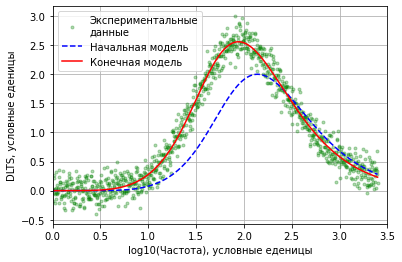

In [30]:
plt.plot(frequency, dlts, '.g', label='Экспериментальные\nданные',alpha=0.3)
plt.plot(new_frequency.numpy(), new_dlts.numpy(), '--b', label='Начальная модель')
plt.plot(new_frequency.numpy(), model.numpy(), 'r', label='Конечная модель')
plt.grid()
plt.xlim([0, 3.5])
# plt.ylim([-3.5, 0])
plt.legend()
plt.ylabel('DLTS, условные еденицы')
plt.xlabel('log10(Частота), условные еденицы')
plt.show()

In [31]:
tf.sqrt(tf.reduce_mean(tf.square(tf.Variable(dlts, dtype='float64') - model)))

<tf.Tensor: shape=(), dtype=float64, numpy=0.16590361483993687>

## 4.9 Проверка модели с коэффициентом $p\_coef \neq 1$

### 4.9.1 Чтение файла

In [32]:
file_name = 'КТ117№1_п1(база 2)_2500Гц-1Гц_1пФ_+10С_-1В-2В_100мВ_20мкс_шаг_0,1.csv'

In [33]:
data = pd.read_csv(file_name, 
                   header = 0,
                   parse_dates = [0],
                   infer_datetime_format = True
                  )
data.head()

,time,frequency_hz,dlts_v,temperature_k,dlts_pf,bs,ls,f_pulse,u1,ur,time_between_meas,integral_time,specimen_name
0,2022-05-06 11:04:58,2500.0000,-2.962,283.160,-0.002962,1,100,20.0,-1.0,-2.0,3.5,3.0,КТ117№1 п1(база 2)
1,2022-05-06 11:05:02,1985.8207,-3.090,283.155,-0.003090,1,100,20.0,-1.0,-2.0,3.5,3.0,КТ117№1 п1(база 2)
2,2022-05-06 11:05:06,1577.3937,-3.359,283.157,-0.003359,1,100,20.0,-1.0,-2.0,3.5,3.0,КТ117№1 п1(база 2)
3,2022-05-06 11:05:10,1252.9686,-3.717,283.143,-0.003717,1,100,20.0,-1.0,-2.0,3.5,3.0,КТ117№1 п1(база 2)
4,2022-05-06 11:05:14,995.2686,-4.068,283.151,-0.004068,1,100,20.0,-1.0,-2.0,3.5,3.0,КТ117№1 п1(база 2)


### 4.9.1 Подготовка данных

In [34]:
frequency = data.frequency_hz.to_numpy()
dlts = data.dlts_pf.to_numpy()

frequency = np.log10(frequency)

scale_factor = np.max(frequency) / (np.max(dlts) - np.min(dlts))
dlts = dlts * scale_factor

In [35]:
dlts = tf.Variable(dlts, dtype = 'float64')

frequency = tf.Variable(frequency, dtype = 'float64')

filling_pulse = tf.Variable(data.f_pulse.mean() * 10**-6, dtype = 'float64')

### 4.9.2 График экспериментальных данных

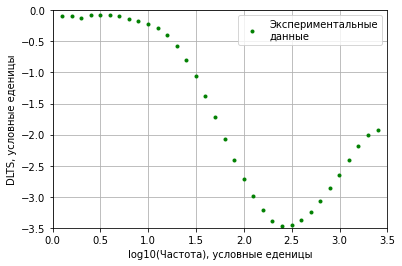

In [36]:
plt.plot(frequency.numpy(), dlts.numpy(), '.g', label='Экспериментальные\nданные', alpha=1)
plt.grid()
plt.xlim([0, 3.5])
plt.ylim([-3.5, 0])
plt.legend()
plt.ylabel('DLTS, условные еденицы')
plt.xlabel('log10(Частота), условные еденицы')
plt.show()

### 4.9.3 Инициализация модели

In [37]:
fs_model = FeqScanModel(amplitude = -2.0,
                        time_constant_power = -2.5,
                        filling_pulse = 20.0*10**-6,
                        fit_p = True
                       )

In [38]:
init_dlts = fs_model(frequency)

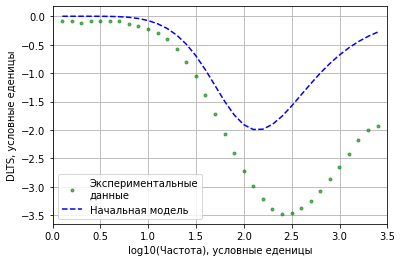

In [39]:
plt.plot(frequency.numpy(), dlts.numpy(), '.g', label='Экспериментальные\nданные', alpha=0.6)
plt.plot(frequency.numpy(), init_dlts.numpy(), '--b', label='Начальная модель')
plt.grid()
plt.xlim([0, 3.5])
# plt.ylim([-3.5, 0])
plt.legend()
plt.ylabel('DLTS, условные еденицы')
plt.xlabel('log10(Частота), условные еденицы')
plt.show()

### 4.9.4 Идентификация модели

In [40]:
fs_model.fit(f_powers = frequency, 
             dlts_vals = dlts,
             learning_rate = 0.2,
             n_iters = 1500,
             stop_val = 10**-10,
             verbose = True
            )

iter # 0
amp: <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=-2.1855542059198756>
tau: <tf.Variable 'time constant power:0' shape=() dtype=float64, numpy=-2.762711027569307>
M: tf.Tensor(5.876559642051986, shape=(), dtype=float64)
p: <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=0.8325093829875283>
Loss: tf.Tensor(1.349399779469152, shape=(), dtype=float64)
iter # 1
amp: <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=-2.372445583613232>
tau: <tf.Variable 'time constant power:0' shape=() dtype=float64, numpy=-2.7411343206565384>
M: tf.Tensor(5.893973813623145, shape=(), dtype=float64)
p: <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=0.6630920401388727>
Loss: tf.Tensor(0.8623180729955958, shape=(), dtype=float64)
iter # 2
amp: <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=-2.5345663191929284>
tau: <tf.Variable 'time constant power:0' shape=() dtype=float64, numpy=-2.751832338177974>
M: tf.Tensor(5.892112594429734, shape=(), dtype=float64)
p

iter # 28
amp: <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=-3.390207219599393>
tau: <tf.Variable 'time constant power:0' shape=() dtype=float64, numpy=-2.812583285099405>
M: tf.Tensor(5.8987005609157865, shape=(), dtype=float64)
p: <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=0.47864122105437534>
Loss: tf.Tensor(0.005178233813863039, shape=(), dtype=float64)
iter # 29
amp: <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=-3.3971572081193546>
tau: <tf.Variable 'time constant power:0' shape=() dtype=float64, numpy=-2.8121094003936435>
M: tf.Tensor(5.898648453642844, shape=(), dtype=float64)
p: <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=0.48079805684808286>
Loss: tf.Tensor(0.004876516773991749, shape=(), dtype=float64)
iter # 30
amp: <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=-3.4035432223581457>
tau: <tf.Variable 'time constant power:0' shape=() dtype=float64, numpy=-2.8116763424743416>
M: tf.Tensor(5.898601449674115, shape=(), dtyp

iter # 55
amp: <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=-3.4677816180696293>
tau: <tf.Variable 'time constant power:0' shape=() dtype=float64, numpy=-2.8075450366077224>
M: tf.Tensor(5.898156180590701, shape=(), dtype=float64)
p: <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=0.5029113621093328>
Loss: tf.Tensor(0.0032463834542372024, shape=(), dtype=float64)
iter # 56
amp: <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=-3.4685209979948914>
tau: <tf.Variable 'time constant power:0' shape=() dtype=float64, numpy=-2.8074996867816893>
M: tf.Tensor(5.898151345641625, shape=(), dtype=float64)
p: <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=0.503144901394728>
Loss: tf.Tensor(0.0032429742736134904, shape=(), dtype=float64)
iter # 57
amp: <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=-3.469202093837675>
tau: <tf.Variable 'time constant power:0' shape=() dtype=float64, numpy=-2.80745795460903>
M: tf.Tensor(5.898146897379034, shape=(), dtype=f

amp: <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=-3.475963953212815>
tau: <tf.Variable 'time constant power:0' shape=() dtype=float64, numpy=-2.8070458576318282>
M: tf.Tensor(5.898103022831229, shape=(), dtype=float64)
p: <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=0.5054982219856157>
Loss: tf.Tensor(0.0032242248405052677, shape=(), dtype=float64)
iter # 81
amp: <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=-3.476059283347025>
tau: <tf.Variable 'time constant power:0' shape=() dtype=float64, numpy=-2.807040076472225>
M: tf.Tensor(5.89810240799183, shape=(), dtype=float64)
p: <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=0.505528391967921>
Loss: tf.Tensor(0.003224168175048575, shape=(), dtype=float64)
iter # 82
amp: <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=-3.4761471221330256>
tau: <tf.Variable 'time constant power:0' shape=() dtype=float64, numpy=-2.807034750317775>
M: tf.Tensor(5.898101841559443, shape=(), dtype=float64)
p: <t

iter # 107
amp: <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=-3.477044080914875>
tau: <tf.Variable 'time constant power:0' shape=() dtype=float64, numpy=-2.8069804012913386>
M: tf.Tensor(5.898096062469729, shape=(), dtype=float64)
p: <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=0.5058401018507248>
Loss: tf.Tensor(0.0032238540275645626, shape=(), dtype=float64)
iter # 108
amp: <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=-3.4770545477047063>
tau: <tf.Variable 'time constant power:0' shape=() dtype=float64, numpy=-2.8069797674963426>
M: tf.Tensor(5.8980959950859955, shape=(), dtype=float64)
p: <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=0.5058434152308072>
Loss: tf.Tensor(0.0032238533444748614, shape=(), dtype=float64)
iter # 109
amp: <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=-3.47706419231874>
tau: <tf.Variable 'time constant power:0' shape=() dtype=float64, numpy=-2.8069791834949798>
M: tf.Tensor(5.898095932996415, shape=(), dt

In [41]:
final_dlts = fs_model(frequency)

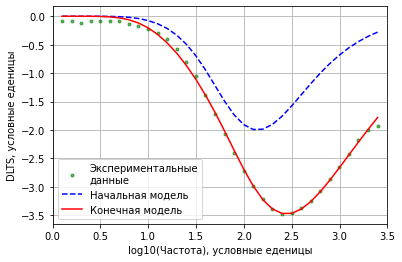

In [42]:
plt.plot(frequency.numpy(), dlts.numpy(), '.g', label='Экспериментальные\nданные', alpha=0.6)
plt.plot(frequency.numpy(), init_dlts.numpy(), '--b', label='Начальная модель')
plt.plot(frequency.numpy(), final_dlts.numpy(), 'r', label='Конечная модель')
plt.grid()
plt.xlim([0, 3.5])
# plt.ylim([-3.5, 0])
plt.legend()
plt.ylabel('DLTS, условные еденицы')
plt.xlabel('log10(Частота), условные еденицы')
plt.show()

In [43]:
fs_model.amplitude / tf.Variable(scale_factor, dtype='float64')

<tf.Tensor: shape=(), dtype=float64, numpy=-0.005351377077024462>

In [44]:
tf.pow(10, fs_model.time_constant_power)

<tf.Tensor: shape=(), dtype=float64, numpy=0.0015596418545129687>

In [45]:
fs_model.phi_model.M

<tf.Tensor: shape=(), dtype=float64, numpy=5.898095500833145>

In [46]:
fs_model.p_coef

<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=0.5058677206625944>

In [47]:
tf.sqrt(tf.reduce_mean(tf.square(final_dlts - dlts)))

<tf.Tensor: shape=(), dtype=float64, numpy=0.05677895701419514>

# 5. Идентификация энергии активации по группе сканов
Эксперементальные данные по GaAs
## 5.1 Чтение данных

In [48]:
def get_file_names(datasets_folder):
    return [datasets_folder + '/' + _ for _ in listdir(datasets_folder)]

def read_datasets(file_names):
    data = pd.read_csv(file_names[0],
                       header=0,
                       parse_dates=[0],
                       infer_datetime_format=True)
    
    for f_name in file_names[1:]:
        data = data.append(pd.read_csv(f_name, header=0, parse_dates=[0], 
                                       infer_datetime_format=True).loc[::10,:],
                           ignore_index = True)
    
    
    return data

In [49]:
DATASET_PATH = '../dataset'

In [50]:
fnames = get_file_names(DATASET_PATH)
data = read_datasets(fnames)

C:\Users\Aleksei\AppData\Local\Temp\ipykernel_5288\1759373501.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append(pd.read_csv(f_name, header=0, parse_dates=[0],
C:\Users\Aleksei\AppData\Local\Temp\ipykernel_5288\1759373501.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append(pd.read_csv(f_name, header=0, parse_dates=[0],
C:\Users\Aleksei\AppData\Local\Temp\ipykernel_5288\1759373501.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append(pd.read_csv(f_name, header=0, parse_dates=[0],
C:\Users\Aleksei\AppData\Local\Temp\ipykernel_5288\1759373501.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.conc

In [51]:
data

,time,frequency_hz,dlts_v,temperature_k,dlts_pf,bs,ls,f_pulse,u1,ur,time_between_meas,integral_time,specimen_name
0,2019-04-03 13:40:45,2500.0000,2.3880,313.826,0.011940,10,50,20.0,1.3,-4.0,3.5,3.0,GaAs 3МС
1,2019-04-03 13:40:49,2443.0925,2.3830,313.838,0.011915,10,50,20.0,1.3,-4.0,3.5,3.0,GaAs 3МС
2,2019-04-03 13:40:52,2387.4812,2.3750,313.833,0.011875,10,50,20.0,1.3,-4.0,3.5,3.0,GaAs 3МС
3,2019-04-03 13:40:56,2333.1355,2.3640,313.826,0.011820,10,50,20.0,1.3,-4.0,3.5,3.0,GaAs 3МС
4,2019-04-03 13:40:59,2280.0269,2.3480,313.830,0.011740,10,50,20.0,1.3,-4.0,3.5,3.0,GaAs 3МС
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1423,2019-04-04 14:16:01,3.1473,0.6064,352.986,0.003032,10,50,20.0,1.3,-4.0,3.5,3.0,GaAs 3МС
1424,2019-04-04 14:16:37,2.5000,0.4970,352.985,0.002485,10,50,20.0,1.3,-4.0,3.5,3.0,GaAs 3МС
1425,2019-04-04 14:17:12,1.9858,0.4504,352.997,0.002252,10,50,20.0,1.3,-4.0,3.5,3.0,GaAs 3МС
1426,2019-04-04 14:17:48,1.5774,0.3951,352.988,0.001975,10,50,20.0,1.3,-4.0,3.5,3.0,GaAs 3МС


In [52]:
data = data[['frequency_hz', 'temperature_k', 'dlts_pf']]
data['rounded_temperature'] = data.temperature_k.round()
data

C:\Users\Aleksei\AppData\Local\Temp\ipykernel_5288\2894104208.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_temperature'] = data.temperature_k.round()


,frequency_hz,temperature_k,dlts_pf,rounded_temperature
0,2500.0000,313.826,0.011940,314.0
1,2443.0925,313.838,0.011915,314.0
2,2387.4812,313.833,0.011875,314.0
3,2333.1355,313.826,0.011820,314.0
4,2280.0269,313.830,0.011740,314.0
...,...,...,...,...
1423,3.1473,352.986,0.003032,353.0
1424,2.5000,352.985,0.002485,353.0
1425,1.9858,352.997,0.002252,353.0
1426,1.5774,352.988,0.001975,353.0


## 5.2 График экспериментальных данных

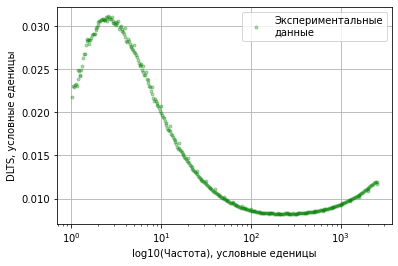

In [53]:
selected = data[data.rounded_temperature == 314]

plt.semilogx(selected.frequency_hz, selected.dlts_pf, '.g', label='Экспериментальные\nданные', alpha=0.3)
plt.grid()
# plt.xlim([0, 3.5])
# plt.ylim([-3.5, 0])
plt.legend()
plt.ylabel('DLTS, условные еденицы')
plt.xlabel('log10(Частота), условные еденицы')
plt.show()

## 5.3 Подготовка данных

In [54]:
frequency = data.frequency_hz.to_numpy()
dlts = data.dlts_pf.to_numpy()
temperature = data.temperature_k.to_numpy()


frequency_power = np.log10(frequency)

scale_factor = np.max(frequency) / (np.max(dlts) - np.min(dlts))
dlts = dlts * scale_factor


frequency_power = tf.Variable(frequency_power, dtype='float64')
dlts = tf.Variable(dlts, dtype='float64')
temperature = tf.Variable(temperature, dtype='float64')

In [55]:
frequency

array([2.5000000e+03, 2.4430925e+03, 2.3874812e+03, ..., 1.9858000e+00,
       1.5774000e+00, 1.2530000e+00])

In [56]:
frequency_power

<tf.Variable 'Variable:0' shape=(1428,) dtype=float64, numpy=
array([3.39794001, 3.38793991, 3.37793996, ..., 0.29793551, 0.19794184,
       0.09795107])>

In [57]:
temperature

<tf.Variable 'Variable:0' shape=(1428,) dtype=float64, numpy=array([313.826, 313.838, 313.833, ..., 352.997, 352.988, 352.982])>

## 5.4 Модель

$$ e_n = BT^2\exp\left(\frac{-\Delta E}{kT} \right) $$
$$ \tau = \frac{1}{e_n} $$
$$ time\_constant\_power = \log_{10}\tau = \frac{\log_e\tau}{\log_e10}$$

$$ F_0 = 10^{frequency\_power}$$
$$ a = \tau F_0 $$
$$ b = t_1 F_0 $$
$$ exp0 = \exp{\left(\frac{-0.05}{a}\right)} $$
$$ exp1 = \exp{\left(\frac{b-0.45}{a}\right)} $$
$$ exp2 = \exp{\left(\frac{-0.5}{a}\right)} $$
$$ exp3 = \exp{\left(\frac{b-0.95}{a}\right)} $$

$$  M = \frac{1}{\max{\left[
    \tau F_0 e^{-\frac{0.05}{\tau F_0}}
    \left(1-e^{\frac{t_1 F_0-0.45}{\tau F_0}}
    -e^{-\frac{0.5}{\tau F_0}}+
    e^{\frac{t_1 F_0-0.95}{\tau F_0}}\right)
    \right]}}
$$

$$ \phi = M \cdot a \cdot exp0 \cdot \left(1.0 - exp1 - exp2 + exp3\right) $$

$$ S\left(\tau,A,F_0, t_1\right) = A \phi\left(\tau,F_0,t_1\right) $$

In [58]:
class DeepLevelModel(tf.Module):
    
    def get_time_constant_power(self, temperature):
        k = tf.Variable(8.617*10**-5, dtype='float64')

        time_constant = 1 / ( self.pre_exp_factor * temperature * temperature * tf.math.exp(-self.energy / (k * temperature) ))

        time_constant_power = tf.math.log(time_constant) / tf.math.log(tf.Variable(10.0, dtype='float64'))

        return time_constant_power
    
    
    def get_phi(self, frequency_power, time_constant_power):
        time_constant = tf.pow(10.0, time_constant_power)
        frequency = tf.pow(10.0, frequency_power)

        a = time_constant * frequency
        b = self.filling_pulse * frequency

        exp0 = tf.exp(-0.05 / (a))
        exp1 = tf.exp((b - 0.45) / (a))
        exp2 = tf.exp(-0.5 / (a))
        exp3 = tf.exp((b - 0.95) / (a))

        phi = self.M * a * exp0 * (1.0 - exp1 - exp2 + exp3)

        return phi
    
    
    def train_M(self,
                time_constant_powers,
                learning_rate=0.1,
                n_iters=100,
                stop_val = None,
                verbose = False
               ):

        prev_loss = tf.Variable(np.inf, dtype='float64')
        max_freq_pow = tf.Variable(-time_constant_powers, dtype='float64')

        for _ in range(n_iters):
            with tf.GradientTape() as tape:
                current_loss = 0.0 - self.get_phi(max_freq_pow, time_constant_powers)

            if verbose:
                print(_)
                print(current_loss)
                print(max_freq_pow)

            if stop_val is not None:
                if tf.math.reduce_all(tf.abs(current_loss - prev_loss) < stop_val):
                    break

            dfreq_pow = tape.gradient(current_loss, max_freq_pow)
            max_freq_pow.assign_sub(learning_rate * dfreq_pow)

            prev_loss = current_loss

        return self.M / self.get_phi(max_freq_pow, time_constant_powers)
    
    
    def __init__(self,
                 amplitude,
                 energy,
                 pre_exp_factor,
                 filling_pulse,
                 fit_p = False,
                 **kwargs):
        super().__init__(**kwargs)
        
        self.amplitude = tf.Variable(amplitude, dtype='float64')
        self.energy = tf.Variable(energy, dtype='float64')
        self.pre_exp_factor = tf.Variable(pre_exp_factor, dtype='float64')
        self.filling_pulse = tf.Variable(filling_pulse, dtype='float64')
        
        self.fit_p = tf.Variable(fit_p, dtype='bool')
        self.p_coef = tf.Variable(1.0, dtype='float64')
        
        self.M = tf.Variable(5.861, dtype='float64')
        
        
    def __call__(self,frequency_power, temperature):
        time_constant_powers = self.get_time_constant_power(temperature)
        
        def get_M(time_constant_powers):
            
            M = self.train_M(time_constant_powers,
                             learning_rate=0.2,
                             n_iters=100,
                             stop_val = 10**-10,
                             verbose = False
                            )
            
#             print(M)
            
            return M
        
        self.M = tf.map_fn(get_M, time_constant_powers)
        
#         print(self.get_phi(frequency_power, time_constant_powers))
        
        return self.amplitude * self.get_phi(frequency_power, time_constant_powers)
    
    
    def fit(self,
            f_powers, 
            temp_vals,
            dlts_vals,
            
            learning_rate = 0.1,
            n_iters = 1000,
            stop_val = None,
            verbose = False
           ):
        
        frequency_powers = tf.Variable(f_powers, dtype='float64')
        temp = tf.Variable(temp_vals, dtype='float64')
        dlts = tf.Variable(dlts_vals, dtype='float64')
        
        prev_loss = tf.Variable(np.inf, dtype='float64')
        
        for _ in range(n_iters):
        
            with tf.GradientTape() as tape:
                predicted_dlts = self.__call__(frequency_power, temp)
                current_loss = tf.reduse_mean(tf.square(dlts-predicted_dlts))
                
                if self.fit_p:
                    d_ampl, denergy, dpre_exp_factor, pd_coef = tape.gradient(current_loss, [self.amplitude,
                                                                                             self.energy,
                                                                                             self.pre_exp_factor,
                                                                                             self.p_coef
                                                                                            ])
                else:
                    d_ampl, denergy, dpre_exp_factor = tape.gradient(current_loss, [self.amplitude,
                                                                                    self.energy,
                                                                                    self.pre_exp_factor
                                                                                   ])

            self.amplitude.assign_sub(learning_rate * dampl)
            self.energy.assign_sub(learning_rate * denergy)
            self.pre_exp_factor.assign_sub(learning_rate * dpre_exp_factor)
            
            
            if self.fit_p:
                self.p_coef.assign_sub(learning_rate * dp_coef)
                                           
            
            if verbose:
                print('iter #', _)
                print('A:',self.amplitude)
                print('E:',self.energy)
                print('B:', self.pre_exp_factor)
                print('M:', self.phi_model.M)
                print('p:', self.p_coef)
                print('Loss:', current_loss)
            
            if stop_val is not None:
                if tf.math.reduce_all(tf.abs(current_loss - prev_loss) < stop_val):
                    break
                    
            prev_loss = current_loss

## 5.5 Инициализация и проверка модели

In [ ]:
energy = tf.Variable(-0.7, dtype='float64')
pre_exp_factor = tf.Variable(1*10**-13, dtype='float64')
filling_pulse = tf.Variable(2 * 10 ** -5, dtype='float64')
amplitude =tf.Variable(3.5, dtype='float64')

deep_level_model = DeepLevelModel(amplitude = amplitude,
                                  energy = energy,
                                  pre_exp_factor = pre_exp_factor,
                                  filling_pulse = filling_pulse,
                                  fit_p = False)

res  = deep_level_model(frequency_power, temperature)

In [ ]:
print(frequency_power)

In [ ]:
print(temperature)

In [ ]:
pd.DataFrame(deep_level_model.M).isna().any()

In [ ]:
pd.DataFrame(res).isna().any()

In [ ]:
pd.DataFrame(res).isna().sum()

In [ ]:
res

## 5.6 Идентификация модели

In [ ]:
deep_level_model.fit(frequency_power, 
                     temperature,
                     dlts,
                     
                     learning_rate = 0.1,
                     n_iters = 1000,
                     stop_val = 10.0**-10,
                     verbose = True
                    )